<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/TP_ADVERSAIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP deep learning sous attaque adversaire (2024)
####Adrien Chan-Hon-Tong
####TP réalisé à partir de résultats de Pol Labarbarie


L'objet de ce TP est de démontrer
- la faciliter de produire des attaques adversaires "white box" sur des réseaux naifs quelles soient invisibles ou par patch
- mais que cela est beaucoup plus dur sur un réseau robustifier (cas invisible)
- ou encore qu'il est beaucoup plus difficile de produire des attaques "transferable"

## generalité
Commençons par télécharger 10 images d'imagenet.

In [1]:
!rm -f *
!wget https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
!unzip data.zip
!ls

rm: cannot remove 'build': Is a directory
rm: cannot remove 'sample_data': Is a directory
--2024-10-04 09:31:47--  https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
Resolving httpmail.onera.fr (httpmail.onera.fr)... 144.204.16.9
Connecting to httpmail.onera.fr (httpmail.onera.fr)|144.204.16.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723589 (707K) [application/force-download]
Saving to: ‘data.zip’

data.zip            100%[===================>] 706.63K   841KB/s    in 0.8s    

2024-10-04 09:31:49 (841 KB/s) - ‘data.zip’ saved [723589/723589]

Archive:  data.zip
 extracting: 0.png                   
  inflating: 1.png                   
 extracting: 2.png                   
 extracting: 3.png                   
  inflating: 4.png                   
 extracting: 5.png                   
 extracting: 6.png                   
 extracting: 7.png                   
 extracting: 8.png                   
 extracting: 9.png            

Affichons les : les 5 premières sont des "avions" et les 5 suivantes des "requins"

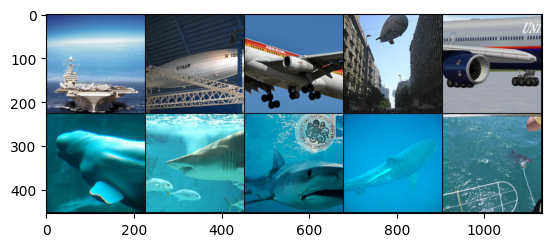

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

x = [torchvision.io.read_image(str(i)+".png") for i in range(10)]
x = torch.stack(x,dim=0).float()/255

visu = torchvision.utils.make_grid(x, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

In [3]:
SHARK, PLANE = [2, 3, 4], [403, 404, 405]
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
resnet = torchvision.models.resnet101(
    weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).eval()

with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)

tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])


On voit que le réseau classe correctement ces images.

## Attaque standard "white box"

On va maintenant rajouter à ces images un petit bruit "invisible" pour l'oeil mais perturbant pour le réseau.

In [4]:
y = torch.Tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2]).long()
cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.nn.Parameter(torch.zeros(x.shape))
optimizer = torch.optim.SGD([attaque],lr=0.005)
for i in range(10):
  z = resnet(normalize(x+attaque))
  ce = cefunction(z,y)
  print(i,float(ce))
  ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign()
  optimizer.step()
  with torch.no_grad():
      # l'attaque doit être invisible
      attaque = torch.clamp(attaque, -10./255,+10./255)

      # attaque+x doit être entre 0 et 1
      lowbound = -x
      uppbound = 1-x
      attaque = lowbound*(attaque<lowbound).float() + uppbound*(attaque>uppbound).float() + attaque *(attaque>=lowbound).float()*(attaque<=uppbound).float()

  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)

0 0.04686766862869263
1 3.540823459625244
2 9.229753494262695
3 15.51185417175293
4 22.443988800048828
5 28.232580184936523
6 33.313053131103516
7 38.62725830078125
8 39.327423095703125
9 44.154701232910156


80% des images "x+attaque" sont désormais mal classées ! (et le label de toutes à changer)
Pourtant, l'attaque ne se voit pas :

tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])
tensor([562, 517, 657, 682, 709, 149, 296,   2, 845,   4])


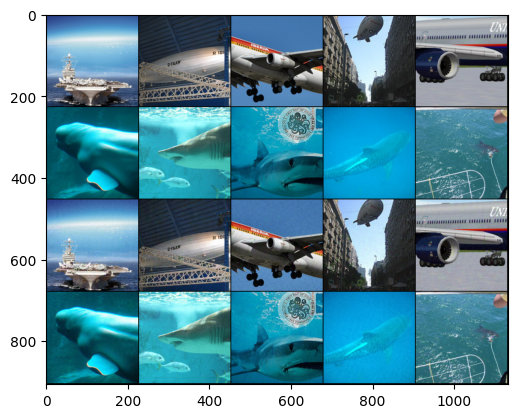

In [5]:
with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)
    z = resnet(normalize(x+attaque))
    _,z = z.max(1)
    print(z)

visu = torch.cat([x,x+attaque],dim=0)
visu = torchvision.utils.make_grid(visu, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

Comment est ce que c'est possible ? Les réseaux ne sont pas du tout lipschitziens...

In [6]:
with torch.no_grad():
    resnet = torchvision.models.resnet101(
        weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
    ).eval()
    resnet.fc = torch.nn.Identity()
    z = resnet(x)
    print(((z[0]-z[5])**2).sum())
    z_ = resnet(x+attaque)
    print(((z[0]-z_[0])**2).sum())

tensor(774.0449)
tensor(506.3102)


On voit que la représentation de l'image 0 devient presque aussi lointaine à cause de l'attaque que la distance avec l'image 5 !
Alors que nous ne voyons même pas la différence !

____________________________________________________________________________
=> retour aux slides (on revient ici après).
____________________________________________________________________________

# Attaque standard par patch "white box"
Maintenant on va regarder la création d'un patch adversarial : pour rappel, le problème des bruits invisibles c'est l'impossibilité de les faire dans le monde physique et l'existance de défense -> deux choses que les patches peuvent bypasser.

On va mettre un patch 36x36 en haut à gauche (remarquons que si le patch est juste noir, ça change rien).

tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])
tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])


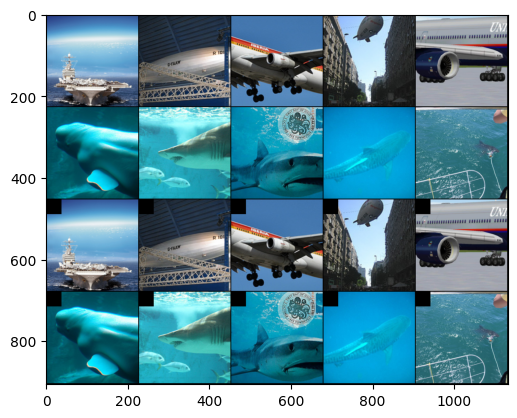

In [7]:
mask = torch.zeros(1,3,224,224)
mask[:,:,0:36,0:36] = 1

resnet = torchvision.models.resnet101(
    weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).eval()
with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)
    z = resnet(normalize(x*(1-mask)))
    _,z = z.max(1)
    print(z)

visu = torch.cat([x,x*(1-mask)],dim=0)
visu = torchvision.utils.make_grid(visu, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

mais s'il est optimisé ?

0 0.053301852196455
1 0.06355644762516022
2 0.0763125866651535
3 0.07919573038816452
4 0.09134728461503983
5 0.10489197075366974
6 0.14180625975131989
7 0.20816895365715027
8 0.3415311574935913
9 0.26848626136779785
10 0.5529042482376099
11 0.3563266396522522
12 0.6168178915977478
13 0.4841131567955017
14 0.8121680021286011
15 0.815456748008728
16 0.8422468304634094
17 0.8819421529769897
18 0.769929826259613
19 0.9125643968582153
20 0.9537666440010071
21 1.2248095273971558
22 1.675524353981018
23 1.9871692657470703
24 1.9389207363128662
25 2.5449771881103516
26 2.3722145557403564
27 2.9336047172546387
28 2.3592400550842285
29 3.0990960597991943
30 2.8682937622070312
31 3.319289445877075
32 3.203747510910034
33 3.5278549194335938
34 3.877960205078125
35 3.8243515491485596
36 3.8635799884796143
37 3.538442611694336
38 3.944089889526367
39 3.682486057281494
tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])
tensor([115, 115, 404, 405, 404, 115, 115, 115, 115, 115])


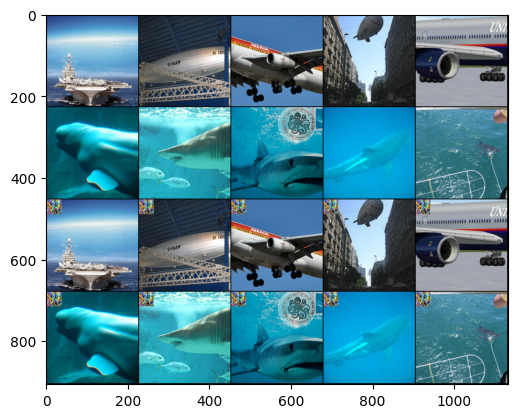

In [8]:
y = torch.Tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2]).long()
cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.nn.Parameter(torch.rand(1,3,224,224))
optimizer = torch.optim.SGD([attaque],lr=0.1)
for i in range(40):
  z = resnet(normalize(x*(1-mask)+mask*attaque))
  ce = cefunction(z,y)
  print(i,float(ce))
  ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign()
  optimizer.step()
  with torch.no_grad():
      # l'attaque doit être dans le domaine image
      attaque = torch.clamp(attaque, 0,1)

  attaque = torch.nn.Parameter(attaque.clone())
  if i<20:
      optimizer = torch.optim.SGD([attaque],lr=0.1)
  else:
      optimizer = torch.optim.SGD([attaque],lr=0.05)

with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)
    z = resnet(normalize(x*(1-mask) + attaque*mask))
    _,z = z.max(1)
    print(z)

visu = torch.cat([x,x*(1-mask)+attaque*mask],dim=0)
visu = torchvision.utils.make_grid(visu, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

Des images ont vu leur label changé (c'est ici pas 100% mais c'est le MÊME patch pour toutes les images - et il n'est pas vraiment optimisé suffisamment longtemps).

## Limites

Ici on montre la facilité de faire une attaque **numérique** contre un réseau **naif** et **connu**.
Heureusement, la situation est très différente contre un réseau *défendu* ou *inconnu* ou quand l'attaque doit être *physiquement réalisable*.

### Réseaux défendus

On trouve très peu de réseaux défendus sur internet pour Imagenet (on trouve surtout des réseaux CIFAR et les rares qu'on peut trouver pour Imagenet comme dans le github https://github.com/MadryLab/robustness sont des réseaux custom).
Aussi, nous allons abandonnés nos avions/requins et faire des petites expériences sur CIFAR10.

Commençons par apprendre un réseau sur CIFAR:

In [9]:
import torch
import torchvision

normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])
trainset = torchvision.datasets.CIFAR10(
    root="build",
    train=True,
    download=True,
    transform=transform,
)

Files already downloaded and verified


In [10]:
resnet = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
).eval()
resnet.fc = torch.nn.Linear(512,10)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)
cefunction = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)
meanloss = torch.zeros(50)
for i,(x,y) in enumerate(trainloader):
    z=resnet(x)
    loss = cefunction(z,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        meanloss[i%50]=loss.clone()
        if i%50==49:
          print(float(meanloss.mean()))
    if i==1000:
        break

1.4229230880737305
0.9971818327903748
0.9116241335868835
0.8577591180801392
0.8076431155204773
0.8027311563491821
0.789408802986145
0.7234569787979126
0.7147898077964783
0.7437455058097839
0.6928415894508362
0.7239859700202942
0.6626895070075989
0.6538287401199341
0.6406874656677246


vérifions que la perfo est pas trop mauvaise même si là on a appris vraiment très très très peu :

In [11]:
testset = torchvision.datasets.CIFAR10(
    root="build",
    train=False,
    download=True,
    transform=transform,
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=500, shuffle=True, num_workers=2
)

with torch.no_grad():
    for x,y in testloader:
        z = resnet(x)
        _,z = z.max(1)
        good = (z==y).float().sum()
        print(float(good/5))
        break

Files already downloaded and verified
79.80000305175781


c'est pas "terrible" mais ça ira pour la preuve de concept...

attaquons 10 images bien classée !

0 0.24504050612449646
1 1.4172234535217285
2 1.6181198358535767
3 1.843016266822815
4 2.0712389945983887
5 2.3154988288879395
6 2.5715649127960205
7 2.8262486457824707
8 3.0474963188171387
9 3.151475667953491
10 3.242994785308838
11 3.277660846710205
12 3.3121650218963623
13 3.3366756439208984
14 3.360492706298828
15 3.378155469894409
16 3.394962787628174
17 3.4082565307617188
18 3.4178810119628906
19 3.4275646209716797
20 3.43451189994812
21 3.4415993690490723
22 3.445584535598755
23 3.4500718116760254
24 3.4525306224823
tensor([7, 5, 7, 4, 0, 9, 8, 1, 7, 4])
tensor([4, 0, 4, 6, 0, 2, 0, 0, 2, 2])


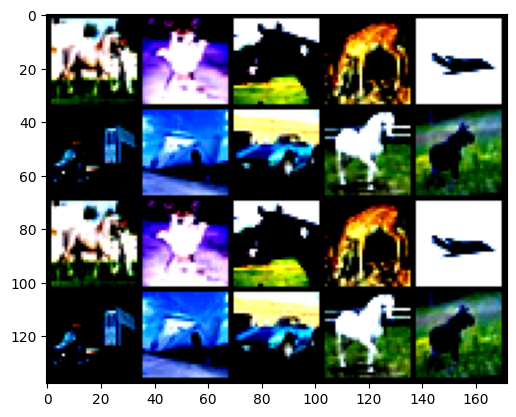

In [12]:
I = [i for i in range(500) if y[i]==z[i]]
I = I[0:10]
y,x=y[I],x[I]
#ces 10 là sont bien classées !

cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.nn.Parameter(torch.zeros(x.shape))
optimizer = torch.optim.SGD([attaque],lr=0.005)
for i in range(25):
  z = resnet(x+attaque)
  ce = cefunction(z,y)
  print(i,float(ce))
  ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign()
  optimizer.step()
  with torch.no_grad():
    # l'attaque doit être invisible
    attaque = torch.clamp(attaque, -10./255,+10./255)

    # attaque+x doit être entre 0 et 1
    lowbound = -x
    uppbound = 1-x
    attaque = lowbound*(attaque<lowbound).float() + uppbound*(attaque>uppbound).float() + attaque *(attaque>=lowbound).float()*(attaque<=uppbound).float()

  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)

with torch.no_grad():
  z = resnet(x)
  _,z = z.max(1)
  print(z)
  z = resnet(x+attaque)
  _,z = z.max(1)
  print(z)

visu = torch.cat([x,x+attaque],dim=0)
visu = torchvision.utils.make_grid(visu, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

Bon même si on est pas à 10/10, on voit que le modèle (pourtant non convergé) est quand même très sensible...

maintenant regardons si on apprend un modèle **robuste**.

In [ ]:
torch.save(resnet,"tmp.pth")
resnetrobuste = torch.load("tmp.pth") #force unrelated copy

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)
cefunction = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnetrobuste.parameters(), lr=0.0001)
meanloss = torch.zeros(50)
for i,(x,y) in enumerate(trainloader):
    #attack x, then update the weight to deal with the fact that z has been attacked
    attaque = torch.nn.Parameter(torch.zeros(x.shape))
    attackoptimizer = torch.optim.SGD([attaque],lr=0.001)
    for _ in range(10):
      z = resnet(x+attaque)
      ce = cefunction(z,y)
      ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
      optimizer.zero_grad()
      ce.backward()
      attaque.grad = attaque.grad.sign()
      optimizer.step()

    #now attaque is frozen
    with torch.no_grad():
        attaque = torch.Tensor(attaque.clone())

    z = resnetrobuste(x+attaque)
    loss = cefunction(z,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        meanloss[i%50]=loss.clone()
        if i%50==49:
          print(float(meanloss.mean()))
          torch.save(resnetrobuste,"tmp.pth")
          resnet = torch.load("tmp.pth") #update the network from which attack is crafted
    if i==400:
        break

<ipython-input-19-54e00eeec531>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnetrobuste = torch.load("tmp.pth") #force unrelated copy


la performance sur les images "normales" devraient avoir baissée

In [17]:
with torch.no_grad():
    for x,y in testloader:
        z = resnetrobuste(x)
        _,z = z.max(1)
        good = (z==y).float().sum()
        print(float(good/5))
        break

80.19999694824219


mais la performance devrait rester similaire sur des images attaquées

0 0.2236376255750656
1 2.419746160507202
2 2.760042190551758
3 3.0860562324523926
4 3.3900210857391357
5 3.6863911151885986
6 3.965379238128662
7 4.232278347015381
8 4.460740089416504
9 4.5740203857421875
10 4.67490291595459
11 4.713034152984619
12 4.746400356292725
13 4.773064613342285
14 4.797447204589844
15 4.813732147216797
16 4.829948902130127
17 4.840339660644531
18 4.85211706161499
19 4.859440803527832
20 4.868216037750244
21 4.872974395751953
22 4.878021240234375
23 4.882907867431641
24 4.886683464050293
tensor([1, 7, 3, 4, 7, 8, 1, 5, 2, 8])
tensor([8, 4, 0, 8, 4, 2, 0, 0, 3, 0])


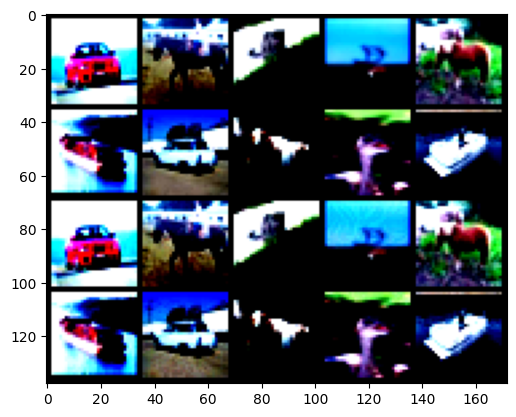

In [18]:
I = [i for i in range(500) if y[i]==z[i]]
I = I[0:10]
y,x=y[I],x[I]
#ces 10 là sont bien classées !

cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.nn.Parameter(torch.zeros(x.shape))
optimizer = torch.optim.SGD([attaque],lr=0.005)
for i in range(25):
  z = resnetrobuste(x+attaque)
  ce = cefunction(z,y)
  print(i,float(ce))
  ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
  optimizer.zero_grad()
  ce.backward()
  attaque.grad = attaque.grad.sign()
  optimizer.step()
  with torch.no_grad():
    # l'attaque doit être invisible
    attaque = torch.clamp(attaque, -10./255,+10./255)

    # attaque+x doit être entre 0 et 1
    lowbound = -x
    uppbound = 1-x
    attaque = lowbound*(attaque<lowbound).float() + uppbound*(attaque>uppbound).float() + attaque *(attaque>=lowbound).float()*(attaque<=uppbound).float()

  attaque = torch.nn.Parameter(attaque.clone())
  optimizer = torch.optim.SGD([attaque],lr=0.005)

with torch.no_grad():
  z = resnetrobuste(x)
  _,z = z.max(1)
  print(z)
  z = resnetrobuste(x+attaque)
  _,z = z.max(1)
  print(z)

visu = torch.cat([x,x+attaque],dim=0)
visu = torchvision.utils.make_grid(visu, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()